# Profiling and Analysis Questions

- Do users purchase different products at different time of day?
- What clusters of aisle purchase standout?
- Do users who reorder have different behaviour? 
- does the behaviour change per number of order (eg.: min vs median, etc)
- do users purchase differently depending on days or weeks since last purchase?
- do users purchase differently on the weekends vs weekday?
- What is the top product/aisle purchased first or last per order?
- Reordered is per product. what products are most reordered by users?
- how many orders per user_id? 

## Aggregations
- days/weeks since last order
- number of orders (better to consider order number instead of count of order_id due to incomplete customer history)
- number of users who reordered
- orders per time of day (numeric or discrete count)


# File and libraries

In [28]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [29]:
%run "scripts/dslabs_functions.py"

# data functions

In [30]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [31]:
test_data=True
# test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 5% sample
    data=data.sample(frac=0.01, replace=False)

    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.25, replace=False)


else:
    data=pd.read_csv(filepath)
    
    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.01, replace=False)



# data=enrich_instacart_df(data)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32430 entries, 1151843 to 243259
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 32430 non-null  int64  
 1   product_id               32430 non-null  int64  
 2   add_to_cart_order        32430 non-null  int64  
 3   reordered                32430 non-null  int64  
 4   user_id                  32430 non-null  int64  
 5   order_number             32430 non-null  int64  
 6   order_dow                32430 non-null  int64  
 7   order_hour_of_day        32430 non-null  int64  
 8   days_since_prior_order   30348 non-null  float64
 9   order_time_of_day        32430 non-null  object 
 10  is_weekend               32430 non-null  int64  
 11  weeks_since_prior_order  30348 non-null  float64
dtypes: float64(2), int64(9), object(1)
memory usage: 3.2+ MB


## variable type definition

In [32]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']
# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order'], 'binary': ['reordered', 'is_weekend'], 'date': [], 'symbolic': ['order_time_of_day'], 'id': ['order_id', 'product_id', 'user_id']}


## drop nulls

In [33]:
# drop any null values
data=data.dropna()

# K means clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html

In [34]:
numeric: list[str] = variable_types["numeric"]
id_cols: list[str] = variable_types["id"]
binary: list[str] = variable_types["binary"]

# select columns that are numeric from list "numeric"

X = data[numeric]
y = data['reordered']
X.describe()


,add_to_cart_order,order_number,order_dow,order_hour_of_day,days_since_prior_order,weeks_since_prior_order
count,30348.000000,30348.000000,30348.000000,30348.000000,30348.000000,30348.000000
mean,8.357486,18.181363,2.736721,13.470278,11.106630,1.558554
std,7.194776,17.609985,2.086036,4.235062,8.808644,1.232128
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,1.000000,10.000000,5.000000,1.000000
50%,6.000000,12.000000,3.000000,13.000000,8.000000,1.000000
75%,12.000000,25.000000,5.000000,16.000000,15.000000,2.000000
max,94.000000,99.000000,6.000000,23.000000,30.000000,4.000000


In [35]:
from sklearn import cluster, mixture
from sklearn.impute import SimpleImputer

# Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

kmeans_algo = cluster.KMeans(n_clusters=5, random_state=1)
kmeans_model = kmeans_algo.fit(X_imputed)

In [36]:
# describe centroids
centroids = kmeans_model.cluster_centers_
pd.DataFrame(data = centroids, columns = X.columns)

,add_to_cart_order,order_number,order_dow,order_hour_of_day,days_since_prior_order,weeks_since_prior_order
0,8.663464,43.693416,2.765753,13.147217,6.052840,0.860978
1,7.991872,7.483180,2.729438,13.584581,7.919121,1.124095
2,8.531479,23.210615,2.739413,13.359260,7.610107,1.090203
3,8.960500,7.443000,2.714500,13.619333,26.386167,3.652000
4,7.287144,73.186297,2.815242,13.173980,3.859122,0.499615


In [37]:
kmeans_model.labels_


array([1, 0, 3, ..., 0, 2, 2])

In [38]:
y #compare against ground truth


1151843    1
2474275    1
2073440    1
373609     0
2949268    0
          ..
417172     0
521714     0
1668613    1
3123889    1
243259     0
Name: reordered, Length: 30348, dtype: int64

In [39]:
from sklearn.metrics import pairwise_distances

def mydistance(x1, x2):
    res = 0.0001
    for j, weight in enumerate([1,2,3,1]):
        res += weight*abs(x1[j]-x2[j])
    return res

def sim_affinity(X):
    return pairwise_distances(X, metric=mydistance)

In [40]:
hier_algo = cluster.AgglomerativeClustering(n_clusters=3, metric=sim_affinity, linkage='average')
hier_model = hier_algo.fit(X)
hier_model.labels_

KeyboardInterrupt: 

In [41]:
from sklearn import metrics
y_pred = kmeans_model.labels_
print("Silhouette:",metrics.silhouette_score(X, y_pred))
print("Silhouette per instance:\n",metrics.silhouette_samples(X, y_pred)[:5],"...")
print("Sum of squared distances:",kmeans_model.inertia_)

Silhouette: 0.30585392080858254
Silhouette per instance:
 [0.29008299 0.48306182 0.51818856 0.04623558 0.21732999] ...
Sum of squared distances: 3719755.6731374403


In [42]:
def purity_score(y_true, y_pred):
    confusion_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix) 

print("Purity:",purity_score(y, y_pred))
print("Adjusted rand index:",metrics.adjusted_rand_score(y, y_pred))

Purity: 0.6297614340318967
Adjusted rand index: 0.005087003784200197


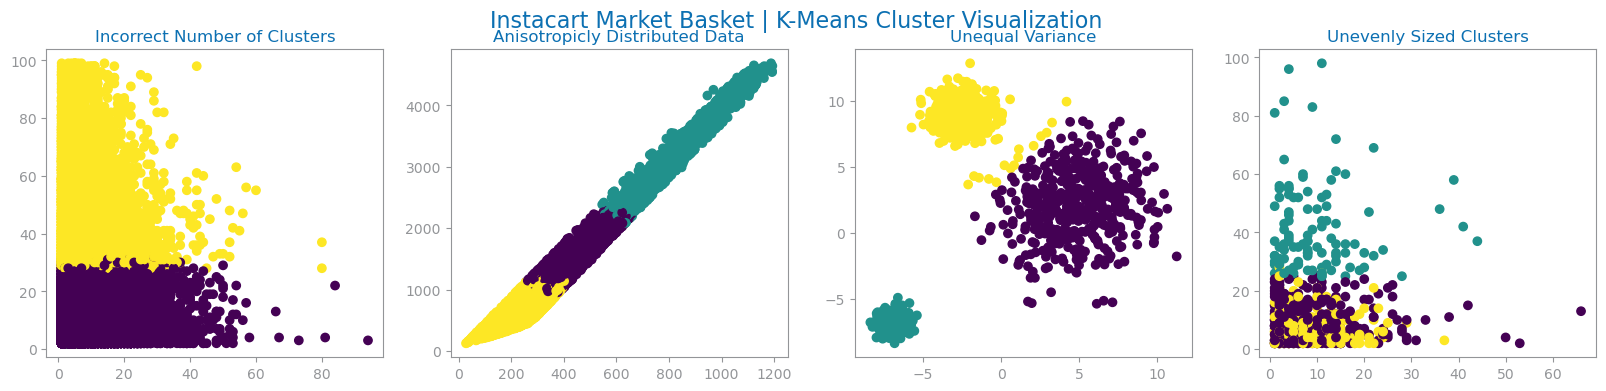

In [43]:
import matplotlib.pyplot as plt

random_state=42
n_samples = 1500


plt.figure(figsize=(20, 4))

# Incorrect number of clusters
y_pred_incorrect = cluster.KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.subplot(141)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_incorrect)
plt.title(f"Incorrect Number of Clusters")

# Anisotropicly distributed data
X_aniso = np.dot(X, X_imputed.T)
y_pred_aniso = cluster.KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
plt.subplot(142)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred_aniso)
plt.title(f"Anisotropicly Distributed Data")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
y_pred_varied = cluster.KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)
plt.subplot(143)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred_varied)
plt.title(f"Unequal Variance")

# Unevenly sized clusters
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred_filtered = cluster.KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)
plt.subplot(144)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred_filtered)
plt.title(f"Unevenly Sized Clusters")

plt.suptitle(f"{file_tag} | K-Means Cluster Visualization", fontsize=16)
plt.show()

